## Introduction: In-Depth Evaluation of Model Performance

Measuring the success of the developed Melanoma Classification Model and understanding its reliability is of vital importance, especially in a critical area such as medical diagnosis. While the overall accuracy of the model provides a first indication, more detailed metrics need to be examined and the nature of the errors made analyzed to gain a comprehensive understanding of its performance. This section presents the basic performance metrics and a detailed error analysis to highlight the strengths and weaknesses of our model.

In particular, determining how prone the model is to different types of errors (false positives and false negatives) is critical to predict its potential impact in clinical applications. Metrics such as sensitivity, specificity, precision, F1 score, as well as ROC (Receiver Operating Characteristic) and Precision-Recall curves will reveal how the model performs at different decision thresholds and how effectively it can distinguish classes.

Analysis of these metrics will allow us to determine in which cases the model is successful and in which scenarios it needs improvement, thus creating a roadmap for future development and enabling the model to be used safely in real-world conditions.

In [1]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score, roc_curve, precision_recall_curve, auc,confusion_matrix
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

drive.mount('/content/drive')
model_path = "/content/drive/MyDrive/melonoma_classification_model/final_finetuned_model.keras"
model = load_model(model_path)
print("Model Loaded Sucessfully")

Mounted at /content/drive
Model Loaded Sucessfully


In [2]:
test_dir = "/content/drive/MyDrive/melonoma_classification_dataset/test" # Test directory for the 1800 image.

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # Image generator class for preprocessing object

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
) # Target size is 224 x 224 with binary classfication.


Found 1890 images belonging to 2 classes.


In [3]:
# Real labels.
y_true = test_generator.classes

# Probabilties with predictions converted to int/label
y_probs = model.predict(test_generator)
y_pred = (y_probs > 0.5).astype(int).flatten()

# Accuracy and classification report
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step
Test Accuracy: 0.8582
Classification Report:
              precision    recall  f1-score   support

      Benign       0.86      0.86      0.86       948
   Malignant       0.86      0.86      0.86       942

    accuracy                           0.86      1890
   macro avg       0.86      0.86      0.86      1890
weighted avg       0.86      0.86      0.86      1890



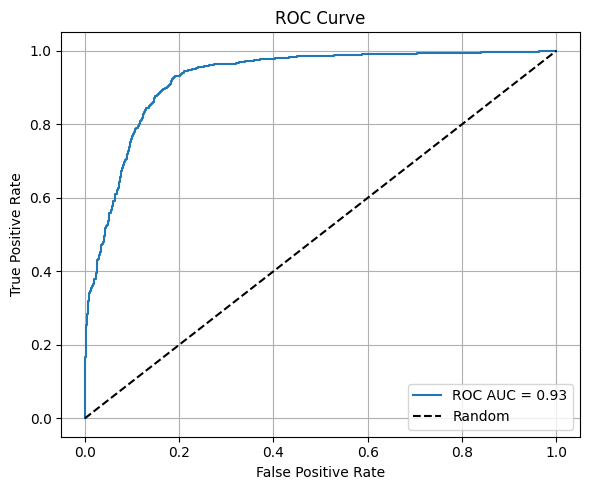

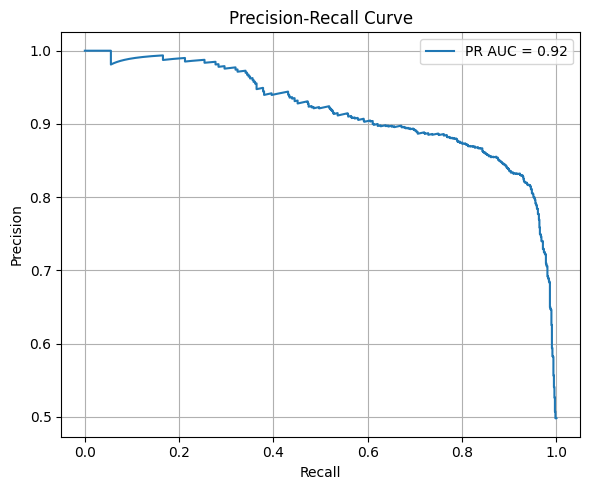

In [4]:
# ROC AUC
roc_auc = roc_auc_score(y_true, y_probs)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_probs)
pr_auc = auc(recall, precision)

# --- ROC Curve ---
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Precision-Recall Curve ---
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Sensitivity (Recall): 0.8599
Specificity: 0.8565


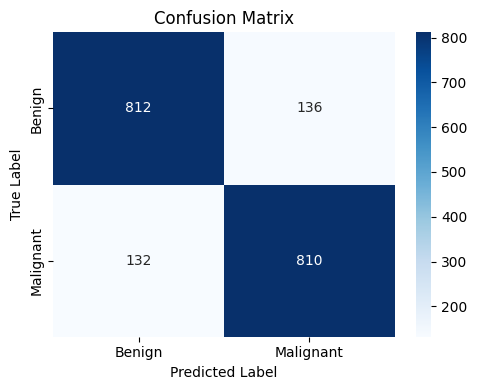

In [5]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Sensitivity (Recall) ve Specificity hesaplama
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Confusion Matrix görselleştirme
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


False Positives: 136
False Negatives: 132


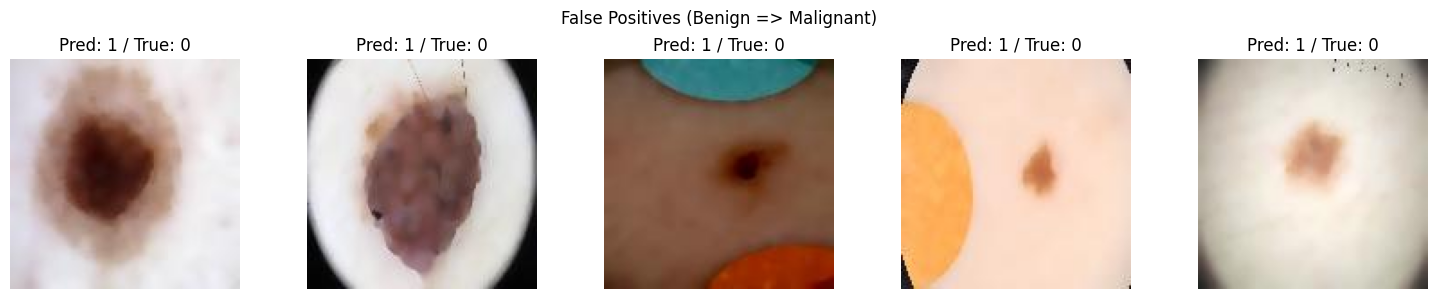

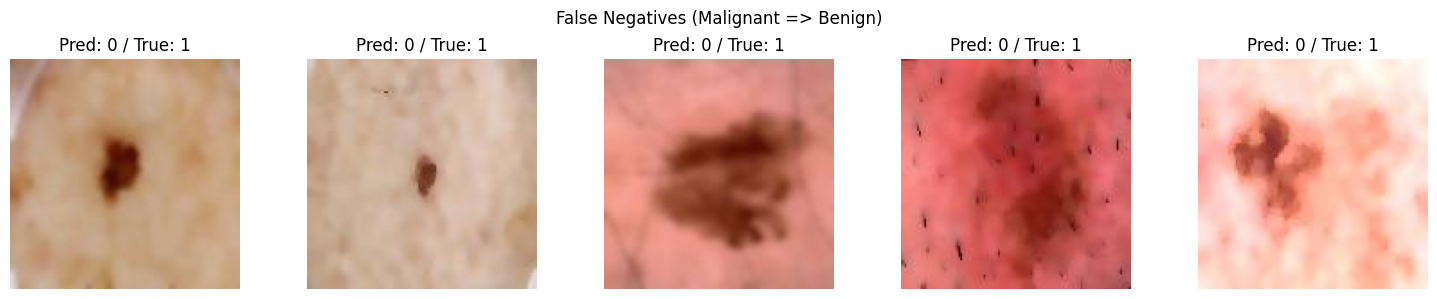

In [6]:
# False Positive (FP)
fp_indices = np.where((y_true == 0) & (y_pred == 1))[0]

# False Negative (FN)
fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]

file_paths = np.array(test_generator.filepaths)

print(f"False Positives: {len(fp_indices)}")
print(f"False Negatives: {len(fn_indices)}")

# Adding images.
def show_error_images(indices, title, max_images=5):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices[:max_images]):
        img = mpimg.imread(file_paths[idx])
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {y_pred[idx]} / True: {y_true[idx]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# First 5 of them.
show_error_images(fp_indices, "False Positives (Benign => Malignant)")
show_error_images(fn_indices, "False Negatives (Malignant => Benign)")


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_6']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


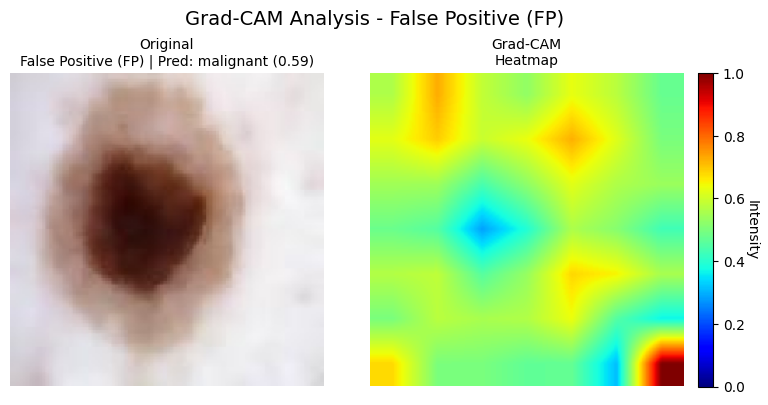

********************************************************************************


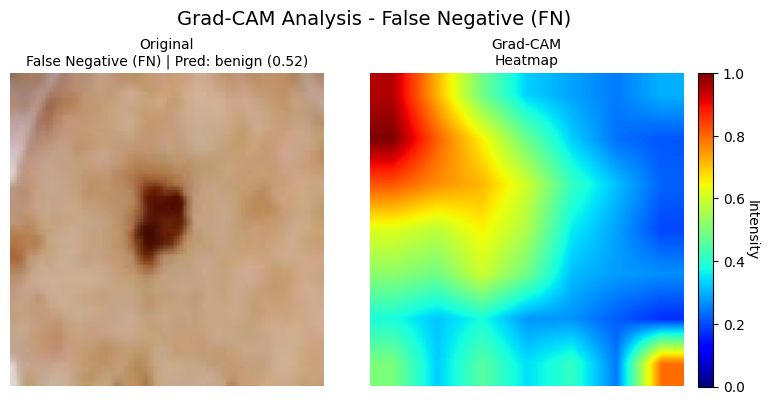

In [7]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Calculating the Grad-CAM image
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv", pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function that generates separate original image and heatmap
def generate_gradcam_image(img_path, model, error_type, last_conv_layer_name="top_conv"):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_batch = np.expand_dims(img_array, axis=0)
    img_array_preprocessed = preprocess_input(img_array_batch)

    # Get prediction
    prediction = model.predict(img_array_preprocessed, verbose=0)[0][0]
    predicted_label = "malignant" if prediction >= 0.5 else "benign"
    confidence = prediction if prediction >= 0.5 else 1 - prediction

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array_preprocessed, model, last_conv_layer_name)

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (224, 224))

    # Original image (RGB format for matplotlib)
    original_img = np.array(img)

    # Create title with error type
    title = f"{error_type} | Pred: {predicted_label} ({confidence:.2f})"

    return original_img, heatmap_resized, title

# Display multiple images with separate original and heatmap views
def display_multiple_gradcams(image_paths, error_type, model, last_conv_layer_name="top_conv"):
    num_images = len(image_paths)

    # Create subplot grid: 2 rows (original images on top, heatmaps on bottom)
    fig, axs = plt.subplots(2, num_images, figsize=(6*num_images, 10))

    # If only one image, make axs 2D for consistent indexing
    if num_images == 1:
        axs = axs.reshape(2, 1)

    for i, path in enumerate(image_paths):
        try:
            original_img, heatmap, title = generate_gradcam_image(
                path, model, error_type, last_conv_layer_name
            )

            # Top row: Original images
            axs[0, i].imshow(original_img)
            axs[0, i].axis('off')
            axs[0, i].set_title(f"Original Image\n{title}", fontsize=12, pad=10)

            # Bottom row: Heatmaps
            im = axs[1, i].imshow(heatmap, cmap='jet', vmin=0, vmax=1)
            axs[1, i].axis('off')
            axs[1, i].set_title("Grad-CAM Heatmap", fontsize=12, pad=10)

            # Add colorbar for heatmap
            cbar = plt.colorbar(im, ax=axs[1, i], fraction=0.046, pad=0.04)
            cbar.set_label('Activation Intensity', rotation=270, labelpad=15)

        except Exception as e:
            print(f"Error processing {path}: {e}")
            # Show error placeholders
            axs[0, i].text(0.5, 0.5, f"Error loading\n{path.split('/')[-1]}",
                          ha='center', va='center', transform=axs[0, i].transAxes)
            axs[0, i].axis('off')
            axs[1, i].text(0.5, 0.5, "Heatmap\nNot Available",
                          ha='center', va='center', transform=axs[1, i].transAxes)
            axs[1, i].axis('off')

    plt.suptitle(f'Grad-CAM Analysis - {error_type}',
                 fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

# Alternative function for side-by-side view (original and heatmap next to each other)
def display_gradcams_side_by_side(image_paths, error_type, model, last_conv_layer_name="top_conv"):
    num_images = len(image_paths)

    # Create subplot grid: each image gets 2 columns (original + heatmap)
    fig, axs = plt.subplots(1, num_images * 2, figsize=(8*num_images, 4))

    # If only one image, make axs 1D array for consistent indexing
    if num_images == 1:
        axs = [axs] if not isinstance(axs, np.ndarray) else axs

    for i, path in enumerate(image_paths):
        try:
            original_img, heatmap, title = generate_gradcam_image(
                path, model, error_type, last_conv_layer_name
            )

            # Original image
            axs[i*2].imshow(original_img)
            axs[i*2].axis('off')
            axs[i*2].set_title(f"Original\n{title}", fontsize=10)

            # Heatmap
            im = axs[i*2 + 1].imshow(heatmap, cmap='jet', vmin=0, vmax=1)
            axs[i*2 + 1].axis('off')
            axs[i*2 + 1].set_title("Grad-CAM\nHeatmap", fontsize=10)

            # Add colorbar
            cbar = plt.colorbar(im, ax=axs[i*2 + 1], fraction=0.046, pad=0.04)
            cbar.set_label('Intensity', rotation=270, labelpad=10)

        except Exception as e:
            print(f"Error processing {path}: {e}")

    plt.suptitle(f'Grad-CAM Analysis - {error_type}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Auto-detect last convolutional layer
def find_last_conv_layer(model):
    """Find the last convolutional layer in the model."""
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 4:
            return layer.name
    return None


# Get false positive and false negative paths
fp_paths = [test_generator.filepaths[i] for i in fp_indices[:1]]
fn_paths = [test_generator.filepaths[i] for i in fn_indices[:1]]

# Side-by-side view (original and heatmap next to each other)
display_gradcams_side_by_side(fp_paths, error_type="False Positive (FP)", model=model)
print("*"*80)
display_gradcams_side_by_side(fn_paths, error_type="False Negative (FN)", model=model)



## Error Analysis: False Positives and False Negatives

Based on the latest confusion matrix (from `download (3).png`), the model's performance on the test set is as follows:

* **True Label: Benign, Predicted Label: Benign (TN - True Negative)**: 812
* **True Label: Benign, Predicted Label: Malignant (FP - False Positive)**: 136
* **True Label: Malignant, Predicted Label: Benign (FN - False Negative)**: 132
* **True Label: Malignant, Predicted Label: Malignant (TP - True Positive)**: 810

And the accompanying classification report shows:
Test Accuracy: 0.8582 (or 0.86)


### False Positives (FP)

* **Count**: There are **136 false positives**. These are cases where the model predicted "Malignant," but the actual label was "Benign."
* **Impact**:
    * From the classification report, the precision for the "Malignant" class is **0.86**. This means that when the model predicts "Malignant," it is correct 86% of the time. The 136 FPs contribute to the 14% error in this precision.
    * In a clinical setting, a false positive can lead to unnecessary anxiety for the patient, further invasive diagnostic procedures (like biopsies), and increased healthcare costs. While generally less critical than a false negative in cancer screening, minimizing FPs is still important, and with 136 such cases, there is a notable rate of false alarms.
* **Potential Patterns in False Positives (Hypotheses for you to investigate by looking at these 136 images):**
    * **Atypical Benign Lesions**: Some benign nevi (moles) can share visual characteristics with early-stage melanomas (e.g., irregular borders, some color variation). These are often called "atypical moles" or "dysplastic nevi." The model might be flagging these as potentially malignant due to these ambiguous features.
    * **Inflammation or Irritation**: Benign lesions that are inflamed, irritated, or have recently changed (e.g., due to scratching) might appear more suspicious and could be misclassified.
    * **Image Quality Issues**: Poor lighting, out-of-focus images, or the presence of artifacts (hairs, air bubbles if using dermoscopy with liquid) could obscure key benign features or create misleading patterns.
    * **Seborrheic Keratoses or Pigmented Basal Cell Carcinomas**: Some other pigmented skin lesions, while not melanoma, can sometimes be confused with it by algorithms if they exhibit certain features.
    * **Borderline Cases**: Lesions that are genuinely difficult for even expert dermatologists to classify without a biopsy. (There are many cases that are determined to be malignant only after biopsy).

---

### False Negatives (FN)

* **Count**: There are **132 false negatives**. These are cases where the model predicted "Benign," but the actual label was "Malignant." **These are the most critical errors in cancer detection.**
* **Impact**:
    * From the classification report, the recall for the "Malignant" class is **0.86**. This means the model correctly identified 86% of all actual malignant cases. The 132 FNs represent the 14% of malignant cases that were missed by the model.
    * A false negative can have severe consequences, as a malignant melanoma might go undiagnosed, leading to delayed treatment and potentially a worse prognosis for the patient. This number of missed cases (132) warrants careful investigation.
* **Potential Patterns in False Negatives (Hypotheses for you to investigate by looking at these 132 images):**
    * **Early-Stage Melanomas**: Very early or small melanomas (e.g., melanoma in situ) might exhibit subtle features that are difficult for the model to pick up, or they might closely resemble benign lesions.
    * **Amelanotic Melanomas**: These are melanomas that lack significant pigmentation. They can be particularly challenging to diagnose visually (both for humans and AI) as they don't fit the typical "dark, irregular mole" pattern.
    * **Nodular Melanomas**: Some nodular melanomas can grow vertically quickly and might appear relatively uniform or symmetrical in their early stages from a top-down view, potentially confusing the model.
    * **Featureless or Uniform Lesions**: Melanomas that lack strong distinguishing features (e.g., very subtle asymmetry, slight color variation that's hard to capture) might be missed.
    * **Obscured Lesions**: If part of the lesion is obscured by hair, poor lighting, or is at the edge of the image, the model might not have enough information.
    * **Rare Melanoma Subtypes**: Less common melanoma variants might not be well-represented in the training data, leading to poorer recognition.
    * **Low-Quality Images**: Similar to FPs, poor image quality can lead to missed diagnoses.

---

### Overall Context and Next Steps

With a test accuracy of approximately 0.86 and F1-scores of 0.86 for both classes, the model demonstrates a reasonable but not exceptional ability to distinguish between benign and malignant lesions. The presence of 136 false positives and 132 false negatives indicates areas for improvement.

While specific ROC AUC or PR AUC values for this particular run were not provided alongside this confusion matrix, these metrics would offer further insight into the model's discriminative power across different thresholds.

The current operating point (which led to this specific confusion matrix) results in a balance where precision and recall for the malignant class are both 0.86. The trade-off between missing a cancer (FN) and causing a false alarm (FP) is always a critical consideration, and these numbers provide a clear basis for discussing that trade-off.

